In [66]:
import os
import json
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

from torch.utils.data import Dataset
import matplotlib.pyplot as plt

## I. Data Handling

In [67]:
globalTransforms = [
    # ensure images are of uniform size
    # this is necessary for the neural network to be able to process the images
    transforms.Resize((224, 224)),

    # ensure the end result is a tensor
    # this converts the image from [0,255] to [0,1]
    # making it compatible with the neural network
    transforms.ToTensor(),

    # normalise the data
    transforms.Normalize(
        # this is the mean and standard deviation of the ImageNet dataset
        # the pixel value, for each channel, is subtracted by the mean and divided by the standard deviation
        # this should shift the pixel values to be centred around zero (mean: 0, std: 1)
        # this allows faster and more stable convergence during optimisation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]

globalTransformer = transforms.Compose(globalTransforms)

# LOAD DATASET
rootDir = globals()['_dh'][0] # os.path.dirname(os.path.abspath(__file__))
dataDir = os.path.join(rootDir, '..', 'data')
artDir = os.path.join(dataDir, 'art')

dataSet = ImageFolder(root=artDir, transform=globalTransformer) # load each subdirectory as a class

with open(os.path.join(dataDir, 'manifest.json'), 'r', encoding='utf-8') as f:
    trueClasses = json.load(f)

print(dataSet)
print(dataSet.classes)
print(trueClasses)

Dataset ImageFolder
    Number of datapoints: 129
    Root location: d:\Programming\UoM\virtual-turntable\server\modelling\sandbox\..\data\art
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
["(What'sTheStory)MorningGlory_Oasis_1995", 'ALoveSupreme_JohnColtrane_1965', 'AMoonShapedPool_Radiohead_2016', 'AbbeyRoad_TheBeatles_1969', 'AfterTheGoldRush_NeilYoung_1970', 'AllThingsMustPass_GeorgeHarrison_1970', 'Animals_PinkFloyd_1977', 'AreYouExperienced_TheJimiHendrixExperience_1967', 'AstralWeeks_VanMorrison_1968', 'AutomaticForThePeople_R.E.M._1992', 'BlondeOnBlonde_BobDylan_1966', 'BloodOnTheTracks_BobDylan_1975', 'Blue_JoniMitchell_1971', 'BornToRun_BruceSpringsteen_1975', 'Carrie&Lowell_SufjanStevens_2015', 'CloseToTheEdge_Yes_1972', 'Closer_JoyDivision_1980', 'DaydreamNation_SonicY

Note: Data augmentation should be done in the future, to create a more robust dataset.

In [68]:
# VERIFY DATASET INTREGRITY
error = False
for i in range(len(dataSet)):
    try:
        img, label = dataSet[i]
    except OSError as e:
        error = True
        print(trueClasses[dataSet.classes[label + 1]])

if (error):
    raise Exception('Dataset is corrupted')

In [69]:
# SPLIT DATA
trainLoader = DataLoader(dataSet, batch_size=8, shuffle=True)
# validationLoader = DataLoader(dataSet, batch_size=8, shuffle=True)

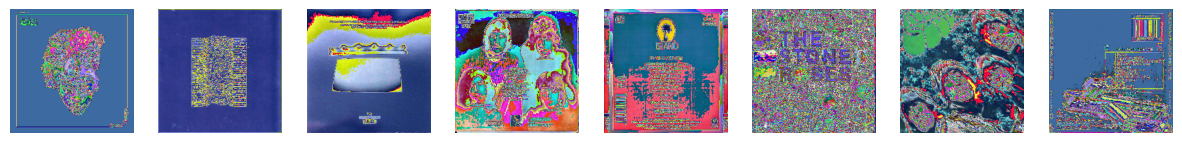

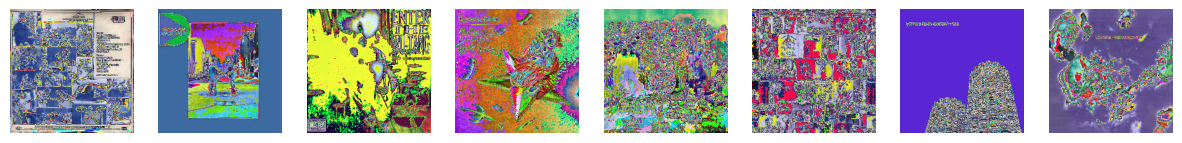

In [70]:
def showBatch(images):
    # Plot the images in the batch
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ii, image in enumerate(images):
        # Apply denormalization if necessary
        image = transforms.ToPILImage()(image)  # Convert to PIL image for display
        axes[ii].imshow(image)
        axes[ii].axis('off')
    plt.show()

for i, (images, _) in enumerate(trainLoader):
    showBatch(images)
    if (i >= 1):
        break

## II. Model

In [71]:
class SimpleCNN(nn.Module):
    """
    This is a simple convolutional neural network, for POC.
    It has two convolutional layers and two fully connected layers (see below).
    It effectively learns the 'ID' of the image (albumName_artistName).
    """

    def __init__(self, numClasses):
        super(SimpleCNN, self).__init__()

        # This is the architecture of the neural network.
        # It is composed of two convolutional layers and two fully connected layers.
        # conv1 -> pool -> conv2 -> pool -> fc1 -> fc2

        # CONVOLUTIONAL LAYER 1
        self.conv1 = nn.Conv2d(
            3, # 3 channels (RBG)
            32, # 32 output filters (feature maps)
            kernel_size=3, # each filter will scan 3x3 patches of the image
            stride=1, # each filter will move 1 pixel at a time
            padding=1 # the input is padded, to esnure the output is the same size as the input
        )

        # MAX-POOLING LAYER
        # reduces spatial dimensions of the input feature maps
        # this reduces the number of parameters and computations in the network
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # CONVOLUTIONAL LAYER 2
        # the 32 feature maps are now fed into a second layer, resulting in 64 output filters
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # FULLY CONNECTED LAYER 1
        self.fc1 = nn.Linear(
            64 * 56 * 56, # 64 feature maps, each 56x56 pixels
            128 # 128 output neurons
        )

        # FULLY CONNECTED LAYER 2
        # this layer outputs logits (raw scores) for each class
        self.fc2 = nn.Linear(128, numClasses)

    def forward(self, x):
        """_summary_

        Args:
            x (_type_): _description_

        Returns:
            _type_: _description_
        """

        # pool the first convolutional layer
        # the size of the feature maps are halved
        x = self.pool(
            # apply the ReLU activation function
            # this introduces non-linearity to the model
            torch.relu(
                # apply the first convolutional layer
                # the 32 filters are applied to the input image
                self.conv1(x)
            )
        )

        # pool the second convolutional layer
        x = self.pool(torch.relu(self.conv2(x)))

        # flatten the feature maps
        x = x.view(-1, 64 * 56 * 56)

        # fully-connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x) # no activation function, as this is handled by the loss function

        return x

model = SimpleCNN(numClasses=len(dataSet.classes))

## III. Training

In [72]:
# LOSS FUNCTION
# used to compute the error between the model's predictions and the true labels
criterion = nn.CrossEntropyLoss()

# OPTIMISER
# updates the model's weights, based on gradients
optimiser = optim.Adam(model.parameters(), lr=0.001)

In [73]:
def train(model, trainLoader, criterion, optimiser, maxEpochs=5):
    """_summary_

    Args:
        model (_type_): _description_
        trainLoader (_type_): _description_
        criterion (_type_): _description_
        optimiser (_type_): _description_
        epochs (int, optional): _description_. Defaults to 5.
    """

    # EPOCH LOOP
    # an epoch is a complete pass through the dataset
    # we do this several times, to allow the model to learn
    for epoch in range(maxEpochs):

        model.train() # set the model to training mode (this is necessary for dropout and batch normalisation)

        # initialsie some statistic-trackers
        runningLoss = 0.0 # cumulative loss
        correct, total = 0, 0 # correct predictions, total predictions

        # TRAINING LOOP
        for images, labels in trainLoader:
            optimiser.zero_grad() # prevent accumulated gradients from previous iterations overflowing

            # FORWARD PASS
            # pass the images into the model, producing a prediction
            outputs = model(images)

            # COMPUTE LOSS
            # compare the model's predictions to the true labels
            loss = criterion(outputs, labels)

            # BACKPROPAGATION
            # compute the gradients of the loss, with respect to the model's parameters/weights
            loss.backward()
            # and update the model's weights accordingly
            optimiser.step()

            # track stats
            runningLoss += loss.item()
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f'(Epoch {epoch+1}) Loss: {runningLoss/len(trainLoader)}\t Accuracy: {accuracy}')

        if (accuracy > 0.99):
            break

train(model, trainLoader, criterion, optimiser, maxEpochs=12)

(Epoch 1) Loss: 7.0402611844679885	 Accuracy: 0.007751937984496124
(Epoch 2) Loss: 4.545221216538373	 Accuracy: 0.007751937984496124
(Epoch 3) Loss: 4.4769883997300095	 Accuracy: 0.06976744186046512
(Epoch 4) Loss: 4.290294815512264	 Accuracy: 0.20155038759689922
(Epoch 5) Loss: 3.675715909284704	 Accuracy: 0.21705426356589147
(Epoch 6) Loss: 2.685059007476358	 Accuracy: 0.5968992248062015
(Epoch 7) Loss: 1.1162846727332663	 Accuracy: 0.813953488372093
(Epoch 8) Loss: 0.3101818501565089	 Accuracy: 0.9534883720930233
(Epoch 9) Loss: 0.10718951215419699	 Accuracy: 0.9844961240310077
(Epoch 10) Loss: 0.04331232484101372	 Accuracy: 0.9922480620155039


<div style="background-color: #f9f9b7; border-left: 6px solid #f1c40f; padding: 10px; color: #000000">
    <strong>Note:</strong> When training with a tiny dataset (~10 classes), high accuracy was reached incredibly quickly (~5 epochs). However, it was noted that raising this to ~100 classes required ~8 or more epochs in order to reach thesame level of convergence.

    The results of the smaller dataset can be seen in previous versions (git) of this notebook.
</div>


<div style="background-color: #f9f9b7; border-left: 6px solid #f1c40f; padding: 10px; color: #000000">
    <strong>Note:</strong> Increasing the dataset size to ~100 classes resulted in the model taking ~1m40s to train to high accuracy (10-12 epochs). GPU optimisation is recommended, if using a larger dataset.
</div>


## IV. Validation

In [74]:
def validate(model, testImage, printResult = True):
    model.eval()

    with torch.no_grad():
        outputs = model(testImage)

        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        predictedProb, predictedClass = torch.max(probabilities, 1)

        predictedID = dataSet.classes[predictedClass.item()]
        predictedProb = predictedProb.item()

        if (printResult):
            print(f'Predicted: {predictedID} ({predictedProb})')
            print(trueClasses.get(predictedID, 'Unknown'))

    return (predictedID, predictedProb)

def validateImage(model, imagePath: str, imageWidth = 350, printResult = True):
    testImage = Image.open(imagePath)
    if (imageWidth > 0):
        displayImage(testImage, imageWidth)

    testImage = globalTransformer(testImage)
    testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

    return validate(model, testImage, printResult)

def displayImage(image: Image, imageWidth = 350):
    aspectRatio = image.height / image.width
    newHeight = int(imageWidth * aspectRatio)
    resizedImage = image.resize((imageWidth, newHeight))
    display(resizedImage)


### Seen Data

When an image is seen by the model, the model should be able to predict the correct label with high accuracy.

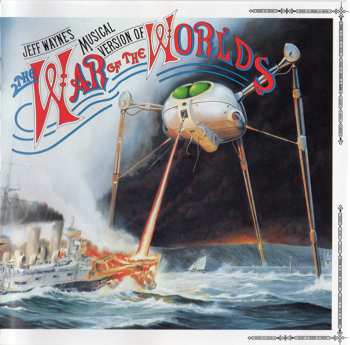

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9998397827148438)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.9998397827148438)

In [75]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978", 'front.png'))

#### 'Seen' Data

Tyically, a model wants to be generalised to unseen data, so that it can be be robust against any data it comes across.

However, in reality, the application of this roject is that it can be reasonably assumed that only album covers will be seen by the model. This is significant, as it means that the user input data will be _very_ similar to the actual test data. For example, look at the above image (official scan used in training) and the below image (a photo similar to what a user might have). Since they are both of the same album, they are almost identical, except for very small differences (particularly colour).

And, furthermore, as a physcial hardware device, it is likely to only ever service a fairly small number of albums in the user's collection.

Therefore, the model should be able to predict the correct label with high accuracy, as 'overfitting' to the training data serves the purpose of the project.

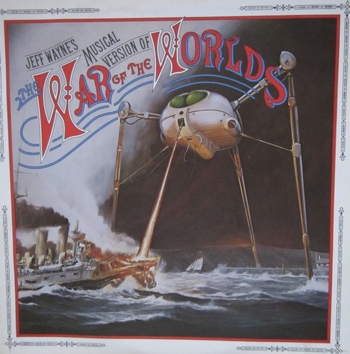

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.18785135447978973)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.18785135447978973)

In [76]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

### Unseen Data

Unseen data (the model is not expected to perform well).

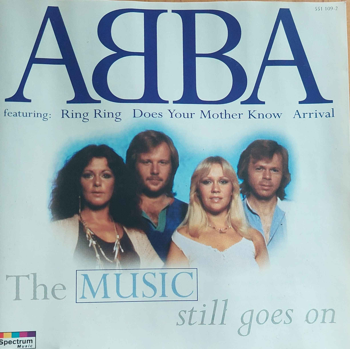

Predicted: Dummy_Portishead_1994 (0.4536242187023163)
{'name': 'Dummy', 'artist': 'Portishead', 'year': 1994}


('Dummy_Portishead_1994', 0.4536242187023163)

In [77]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'TheMusicStillGoesOn_ABBA.jpg'))

Note: the sum of the probabilities will be 1. Therefore, with a small datatset, the model may be confidently wrong (i.e. a high probability for the wrong class), as this is moreso a measure of 'how confident I am it is this, compared to the other options', as opposed to 'how confident I am that it is this, and not anything else'. This is important to note when interpreting the results (we should have a high standard for confidence). However, as the dataset grows, the liklihood of any one class being highly-favoured, when the true result lies outside of the trained classes, should decrease.

#### Bad Data

In [78]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'MahoganyJack.jpg'))

Predicted: _null (0.3074960708618164)
Unknown


('_null', 0.3074960708618164)

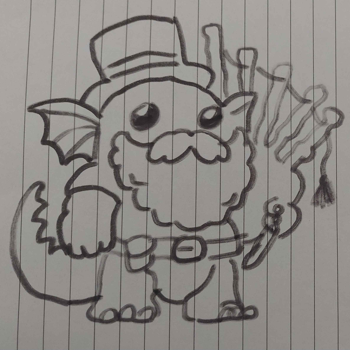

Predicted: Highway61Revisited_BobDylan_1965 (0.3454369306564331)
{'name': 'Highway 61 Revisited', 'artist': 'Bob Dylan', 'year': 1965}


('Highway61Revisited_BobDylan_1965', 0.3454369306564331)

In [79]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Haranthur.jpg'))

In [80]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Dumplings.jpg'))

Predicted: InTheAeroplaneOverTheSea_NeutralMilkHotel_1998 (0.9943086504936218)
{'name': 'In The Aeroplane Over The Sea', 'artist': 'Neutral Milk Hotel', 'year': 1998}


('InTheAeroplaneOverTheSea_NeutralMilkHotel_1998', 0.9943086504936218)

In these examples, we see that the image is (fairly) confidently wrong, about this data, as it has not concept of what is a coverart, and what is not.

The best way to counter this, is to have a confidence threshold. If the model is not confident, it should not make a prediction, without using other fallback methods (e.g. OCR, etc.). As  the dataset increases, the confidence level should naturally decrease for unseen data, as the model will have more data to compare against.

### 'Empty' Data

However, there is one example of bad data that we can theoretically handle quite well: as the camera will be fixed, we have a strong idea of what background to expect. Therefore, we can have one class be trained on the background, whichmeans that when there is 'no data', it will be classified as the background. This will be useful for the 'unseen data' section, as we can see how well the model can differentiate between the background and the other classes.

In [81]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art', '_null', 'null.jpg'))

Predicted: _null (0.1794571727514267)
Unknown


('_null', 0.1794571727514267)

**As the results of this data are essentially just a matter of 'is this already seen'?, formal evaluation of the model has been skipped, for now.**

## V. Observations

### 1. Model performs terribly on data belonging to unseen classes.
This is expected, and can be improved by:
- using a multi-headed model, for deeper analysis;
- using alternative fallback methods, such as barcode scanning, or OCR;
- and can be minimised by using a larger dataset, with more classes.

### 2. This model is not robust.
Rotating, flipping, warping, discolouring, and other augmentations to the base image can result in a completely different prediction. This is expected, and can be improved by:
- using an augmentated dataset, to make these cases not so 'unseen';
- using a larger dataset, with more classes (the arbitrary similarities between classes will be less likely to be learned);

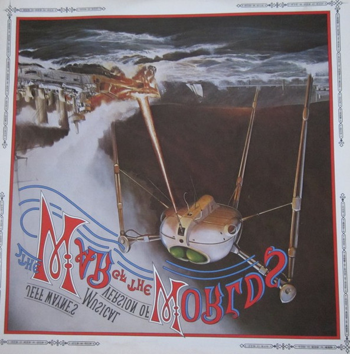

Predicted: PetSounds_TheBeachBoys_1966 (0.1727968156337738)
{'name': 'Pet Sounds', 'artist': 'The Beach Boys', 'year': 1966}


('PetSounds_TheBeachBoys_1966', 0.1727968156337738)

In [82]:
testImage = Image.open(os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

# AUGMENT IMAGE
testImage = testImage.transpose(Image.FLIP_TOP_BOTTOM)

displayImage(testImage, 350)

# VALIDATE
testImage = globalTransformer(testImage)
testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

validate(model, testImage)

We can see that the model is still able to correctly identify this example, even when flipped. However, this specififc examle is quite symmetrical (the corner symbols, red border, etc.).

If we are to further distort the image, the results can become incorrect:

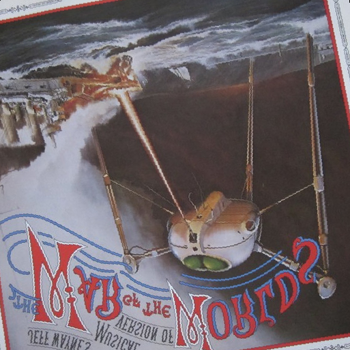

Predicted: BloodOnTheTracks_BobDylan_1975 (0.25023946166038513)
{'name': 'Blood On The Tracks', 'artist': 'Bob Dylan', 'year': 1975}


('BloodOnTheTracks_BobDylan_1975', 0.25023946166038513)

In [83]:
testImage = Image.open(os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

# AUGMENT IMAGE
testImage = testImage.transpose(Image.FLIP_TOP_BOTTOM)
testImage = testImage.rotate(10)
testImage = testImage.crop((40, 40, 553, 553))

displayImage(testImage, 350)

# VALIDATE
testImage = globalTransformer(testImage)
testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

validate(model, testImage)

In [84]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(3).jpg"))

Predicted: TheStoneRoses_TheStoneRoses_1989 (0.15563413500785828)
{'name': 'The Stone Roses', 'artist': 'The Stone Roses', 'year': 1989}


('TheStoneRoses_TheStoneRoses_1989', 0.15563413500785828)

## VI. Experiments

### 1. How does artificial augmentation improve results?

In [85]:
testingData = {
    "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png": "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
    "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(3).jpg": "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
    "TheMusicStillGoesOn_ABBA.jpg": None,
    "MahoganyJack.jpg": None,
    "Haranthur.jpg": None,
    "Dumplings.jpg": None,
}

def validateResult(iota, prediction):
    expected = testingData.get(iota, None)
    if (prediction):
        if (expected is None):
            # no expected class, so expecting low confidence
            if (prediction[1] >= 0.5):
                print(f"[{iota}]\tUnexpected high confidence:\t{prediction[0]} ({prediction[1]})")
                return False
        else:
            if (prediction[0] != expected):
                print(f"[{iota}]\tUnexpected class:\t{prediction[0]} ({prediction[1]})")
                return False

        return True
    raise Exception(f"Unexpected result ({iota}): {prediction}")

validateResult("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png", ("IncorrectClass", 0.8))
validateResult("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png", ("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978", 0.8))

validateResult("MahoganyJack.jpg", ("IncorrectClass", 0.9999))
validateResult("MahoganyJack.jpg", ("IncorrectClass", 0.1))

[JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png]	Unexpected class:	IncorrectClass (0.8)
[MahoganyJack.jpg]	Unexpected high confidence:	IncorrectClass (0.9999)


True

[JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(3).jpg]	Unexpected class:	TheStoneRoses_TheStoneRoses_1989 (0.15563413500785828)


[Dumplings.jpg]	Unexpected high confidence:	InTheAeroplaneOverTheSea_NeutralMilkHotel_1998 (0.9943086504936218)


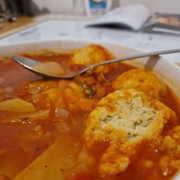

In [ ]:
def validateResults(model, testingData):
    for iota in testingData.keys():
        imagePath = os.path.join(rootDir, '..', 'data', 'misc', iota)
        prediction = validateImage(model, imagePath, imageWidth=0, printResult=False)
        # if (validateResult(iota, prediction) is False):
        #     displayImage(Image.open(imagePath), imageWidth=180)

validateResults(model, testingData)

In [87]:
# demonstration of 'on-the-fly' data augmentation
augmentedTransforms = [
    transforms.RandomHorizontalFlip(),
]

augmentedTransformer = transforms.Compose(globalTransforms + augmentedTransforms)

augmentedDataSet = ImageFolder(root=artDir, transform=augmentedTransformer)
trainLoader = DataLoader(augmentedDataSet, batch_size=10, shuffle=False)

temp = None
count = 0
for i in range(10):
    for images, labels in trainLoader:
        if (temp is None):
            print(torch.bincount(labels).max().item() > 1) # multiple images per class
        elif (not torch.equal(images[0], temp)):
            count += 1
        temp = images[0]
        break
print(count != i) # augmentation is performed 'on the fly' (images vary between epochs)


True
True


**Benchmark Results of Un-Augmented Data, for Comparison:**

| Epoch   | Loss      | Accuracy       |
|---------|-----------|----------------|
| Epoch 1 | 6.4425    | 0.0078         |
| Epoch 2 | 4.5237    | 0.0233         |
| Epoch 3 | 4.3805    | 0.0775         |
| Epoch 4 | 3.6864    | 0.3876         |
| Epoch 5 | 2.1472    | 0.6357         |
| Epoch 6 | 0.9304    | 0.8217         |
| Epoch 7 | 0.3480    | 0.9302         |
| Epoch 8 | 0.1796    | 0.9767         |
| Epoch 9 | 0.0738    | 0.9922         |

In [88]:
# Custom dataset to combine original and multiple augmentations
class ArtificiallyAugmentedDataset(Dataset):
    def __init__(self, originalDataset, transform, augmentTransform, numAugmentations=4):
        self.originalDataset = originalDataset
        self.transform = transform
        self.augmentTransform = augmentTransform
        self.numAugmentations = numAugmentations

    def __len__(self):
        # Include original images and augmented copies
        return len(self.originalDataset) * (1 + self.numAugmentations)

    def __getitem__(self, idx):

        originalIdx = idx // (1 + self.numAugmentations)

        if ((idx % (1 + self.numAugmentations)) == 0):
            # Return the original image
            image, label = self.originalDataset[originalIdx]
            transformedImage = self.transform(image)
            return transformedImage, label

        # Return the augmented image
        image, label = self.originalDataset[originalIdx]
        augmentedImage = self.augmentTransform(image)
        return augmentedImage, label


In [89]:
# Example
vanillaDataSet = ImageFolder(root=artDir)

augmentedTransforms = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
]
augmentedTransformer = transforms.Compose(globalTransforms + augmentedTransforms)

# Initialise the combined dataset with multiple augmentations
augmentedDataSet = ArtificiallyAugmentedDataset(vanillaDataSet, globalTransformer, augmentedTransformer, numAugmentations=4)

# Define the DataLoader with shuffling
trainLoader = DataLoader(augmentedDataSet, batch_size=8, shuffle=False)

print(len(vanillaDataSet))
print(len(augmentedDataSet))

for i, (images, _) in enumerate(trainLoader):
    showBatch(images)
    if (i >= 1):
        break

129
645


#### Rotations

In [94]:
class RandomFlip(torch.nn.Module):
    """Flip the given image randomly with a given probability.
    If the image is torch Tensor, it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be flipped.

        Returns:
            PIL Image or Tensor: Randomly flipped image.
        """
        if torch.rand(1) < self.p:
            return transforms.functional.vflip(
                transforms.functional.hflip(img)
            )
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"


In [96]:
# Create an augmented dataset
# this improves the model's generalisation (increasing robustness to variations in the input data)
augmentedTransforms = [
    transforms.RandomRotation(30),
    RandomFlip(),
]
augmentedTransformer = transforms.Compose(globalTransforms + augmentedTransforms)

# Create a single dataset, combining the original and augmented datasets
# preserving the original dataset (un-augmented) improves the stability of the model
augmentedDataSet = ArtificiallyAugmentedDataset(vanillaDataSet, globalTransformer, augmentedTransformer, numAugmentations=4)

trainLoader = DataLoader(augmentedDataSet, batch_size=40, shuffle=True)

# Train the model
augmentedModel = SimpleCNN(numClasses=len(dataSet.classes))

criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(augmentedModel.parameters(), lr=0.001)

train(augmentedModel, trainLoader, criterion, optimiser, maxEpochs=12)


(Epoch 1) Loss: 6.156204896814683	 Accuracy: 0.03875968992248062
(Epoch 2) Loss: 4.004921548506793	 Accuracy: 0.07596899224806201
(Epoch 3) Loss: 2.9767587044659782	 Accuracy: 0.27596899224806204
(Epoch 4) Loss: 1.6859051760505228	 Accuracy: 0.5395348837209303
(Epoch 5) Loss: 0.7809860780835152	 Accuracy: 0.7968992248062016
(Epoch 6) Loss: 0.47091862033395204	 Accuracy: 0.8945736434108527
(Epoch 7) Loss: 0.2952697125866133	 Accuracy: 0.9302325581395349
(Epoch 8) Loss: 0.10692301085766624	 Accuracy: 0.9813953488372092
(Epoch 9) Loss: 0.05151711716590559	 Accuracy: 0.9906976744186047


<div style="background-color: #f9f9b7; border-left: 6px solid #f1c40f; padding: 10px; color: #000000">
    <strong>Note:</strong> It was learnt that disabling shuffle made the model perform worse.
</div>


<div style="background-color: #f9f9b7; border-left: 6px solid #f1c40f; padding: 10px; color: #000000">
    <strong>Note:</strong> 'On-the-fly' augmentation hampered the speed of the training process. It is recommended to increase batch size accordingly.
</div>


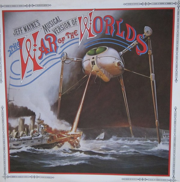

Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.18785135447978973)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}
Predicted: AfterTheGoldRush_NeilYoung_1970 (0.5658613443374634)
{'name': 'After The Gold Rush', 'artist': 'Neil Young', 'year': 1970}


In [97]:
res1 = validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"), imageWidth=180)
res2 = validateImage(augmentedModel, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"), imageWidth=0)

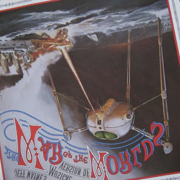

Predicted: BloodOnTheTracks_BobDylan_1975 (0.25023946166038513)
{'name': 'Blood On The Tracks', 'artist': 'Bob Dylan', 'year': 1975}
Predicted: JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.3146528899669647)
{'name': "Jeff Wayne's Musical Version of The War of the Worlds", 'artist': 'Jeff Wayne', 'year': 1978}


("JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
 0.3146528899669647)

In [100]:
testImage = Image.open(os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

# AUGMENT IMAGE
testImage = testImage.transpose(Image.FLIP_TOP_BOTTOM)
testImage = testImage.rotate(10)
testImage = testImage.crop((40, 40, 553, 553))

displayImage(testImage, 180)

# VALIDATE
testImage = globalTransformer(testImage)
testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

validate(model, testImage)
validate(augmentedModel, testImage)

[JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png]	Unexpected class:	AfterTheGoldRush_NeilYoung_1970 (0.5658613443374634)


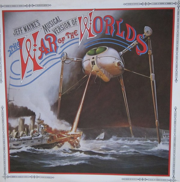

[JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(3).jpg]	Unexpected class:	Animals_PinkFloyd_1977 (0.510797917842865)


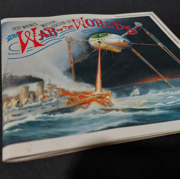

[TheMusicStillGoesOn_ABBA.jpg]	Unexpected high confidence:	JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9771336317062378)


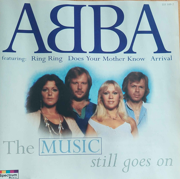

[Haranthur.jpg]	Unexpected high confidence:	Highway61Revisited_BobDylan_1965 (0.6426418423652649)


In [99]:
validateResults(augmentedModel, testingData)

#### Scales / Crops

#### 'Lighting' (colour augmentation)

#### Wraping

### 2. How does the chosen image transformation affect results?
#### Does fidelity improve accuracy?